<a href="https://colab.research.google.com/github/reitezuz/notebooks-for-NES2-2024/blob/main/lecture_09/simple_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time series prediction - Jena Climate Dataset

Inspired by: https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter10_dl-for-timeseries.ipynb

# Jena Climate Dataset
The dataset contains meteorological data recorded in Jena, Germany, from 2009 to 2016. Measurement frequency: Every 10 minutes. It is suitable for time series analysis and weather prediction.
- File type: CSV (compressed in a ZIP file).

**Variables:**
- `Datetime` - Date and time of measurement.
- `Temperature (°C)` - Temperature.
- `Pressure (hPa)` - Atmospheric pressure.
- `Humidity (%)` - Relative humidity.
- `Wind speed (m/s)` - Wind speed.
- `Wind direction (°)` - Wind direction in degrees.
- `Radiation (W/m²)` - Solar radiation intensity.
- ...

**Uses:**
- Temperature or other meteorological variable prediction.
- Seasonal and trend analysis in time series data.

**Source:**
Dataset download: [jena_climate_2009_2016.csv.zip](https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip)

https://www.kaggle.com/datasets/mnassrib/jena-climate


1. Download the zip file with the data
2. Extract the zip file

In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

import os
# Clean up by removing the downloaded zip file
os.remove("jena_climate_2009_2016.csv.zip")


--2024-12-04 09:41:39--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 3.5.12.233, 52.216.218.120, 52.217.121.216, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|3.5.12.233|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  20.6MB/s    in 0.6s    

2024-12-04 09:41:40 (20.6 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


## Observe the data

In [2]:
import pandas as pd
import numpy as np
import os

file_path = "jena_climate_2009_2016.csv"

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(file_path)

# Extract header and number of rows using pandas
header = list(df.columns)
num_rows = len(df)

# Extract 'Temperature (°C)' column into temperature array
temperature = df['T (degC)'].values

# Create raw_data array (excluding the Date Time column)
raw_data = df.drop(columns=['Date Time']).values


print("Header:", header)
print("Number of columns:", len(header))
print("Number of rows:", num_rows)
print("Temperature array shape:", temperature.shape)
print("Raw data array shape:", raw_data.shape)

# Example: Display first few rows of the DataFrame
print(df.head())



Header: ['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)', 'wd (deg)']
Number of columns: 15
Number of rows: 420451
Temperature array shape: (420451,)
Raw data array shape: (420451, 14)
             Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
0  01.01.2009 00:10:00    996.52     -8.02    265.40        -8.90    93.3   
1  01.01.2009 00:20:00    996.57     -8.41    265.01        -9.28    93.4   
2  01.01.2009 00:30:00    996.53     -8.51    264.91        -9.31    93.9   
3  01.01.2009 00:40:00    996.51     -8.31    265.12        -9.07    94.2   
4  01.01.2009 00:50:00    996.51     -8.27    265.15        -9.04    94.1   

   VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  \
0          3.33          3.11          0.22       1.94             3.12   
1          3.23          3.02          0.21       1.

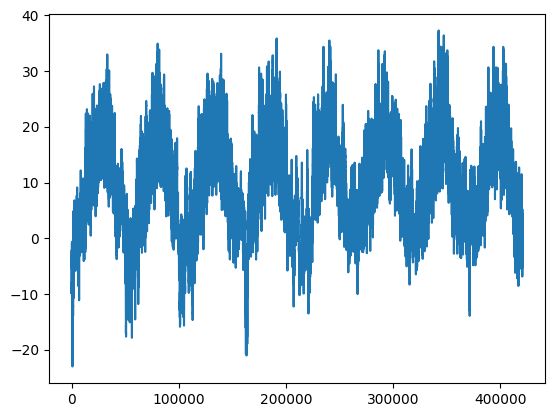

In [3]:
# Plotting the temperature timeseries
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

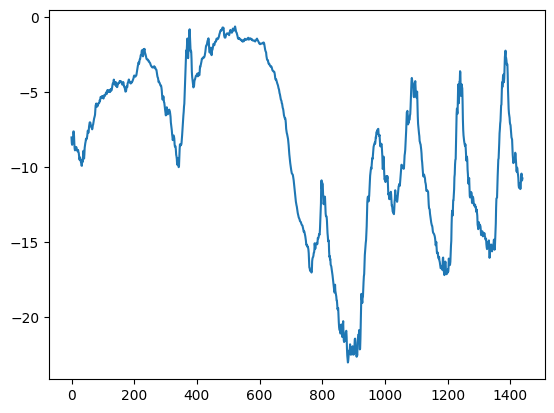

In [4]:
# Plotting the first 10 days of the temperature timeseries (24*6 = 144 points per day)
plt.plot(range(1440), temperature[:1440])

## Simple Example: Dataset for time series

- create a simple timeseries training set from an array:
- https://keras.io/api/data_loading/timeseries/

In [5]:
import numpy as np
from tensorflow import keras

int_sequence = np.arange(10)
print(int_sequence)

dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    print("")
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))


[0 1 2 3 4 5 6 7 8 9]

[0, 1, 2] 3
[1, 2, 3] 4

[2, 3, 4] 5
[3, 4, 5] 6

[4, 5, 6] 7


## Our task

- We will use only data measured once per hour instead of all data (measured every 10 minutes).
- Based on the values from the previous 5 days, we will predict the temperature 24 hours ahead.
   - 24 points per day, 120 points in 5 days

## Prepare the data

In [6]:
# Training, validation and testing data
num_train_samples = int(0.5 * len(raw_data)) # 50 % training data
num_val_samples = int(0.25 * len(raw_data))  # 25 % validation and testing data
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

# Normalize the data:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

# Create the training, validation and testing data sets:
sampling_rate = 6        # we will use each 6th sample (1 per hour)
sequence_length = 120    # we will use data from 120 hours (5 days)
delay = sampling_rate * (sequence_length + 24 - 1) # target: value 24 hours after the end of sequence
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)


for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114
samples shape: (256, 120, 14)
targets shape: (256,)


In [7]:
# Data frame for results
import pandas as pd

columns = ["Model Name", "Details", "Train MAE", "Val MAE", "Test MAE"]
results_df = pd.DataFrame(columns=columns)

## Compute the common-sense baseline MAE
- predict the temperature 24 hours ago

In [8]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

train_loss = evaluate_naive_method(train_dataset)
val_loss = evaluate_naive_method(val_dataset)
test_loss = evaluate_naive_method(test_dataset)
print(f"Training MAE: {train_loss:.2f}")
print(f"Validation MAE: {val_loss:.2f}")
print(f"Test MAE: {test_loss:.2f}")

# Add results to the dataframe:
new_entry = {
    "Model Name" : "Baseline",
    "Details" : "Previous day",
    "Train MAE" : train_loss,
    "Val MAE" : val_loss,
    "Test MAE" : test_loss,
}
results_df = pd.concat([results_df, pd.DataFrame([new_entry])], ignore_index=True)

# View and and save the dataframe:
print("Results:")
print(results_df)
model_dir = "./models/"
if not os.path.exists(os.path.dirname(model_dir)):
    os.makedirs(os.path.dirname(model_dir))
results_df.to_csv("models/jena_results.csv", index=False)

Training MAE: 2.69
Validation MAE: 2.44
Test MAE: 2.62
Results:
  Model Name       Details  Train MAE   Val MAE  Test MAE
0   Baseline  Previous day   2.691644  2.441733  2.622036


<ipython-input-8-0a592d485080>:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([new_entry])], ignore_index=True)


## Define and train the model: a simple MLP

In [9]:
# flattten the data:

import tensorflow as tf

def reshape_samples(samples, targets):
    batch_size = tf.shape(samples)[0] # Use tf.shape to get the dynamic batch size
    reshaped_samples = tf.reshape(samples, (batch_size, -1))  # Flatten the samples
    return reshaped_samples, targets

train_dataset_fl = train_dataset.map(reshape_samples)
val_dataset_fl = val_dataset.map(reshape_samples)
test_dataset_fl = test_dataset.map(reshape_samples)

for samples, targets in train_dataset_fl:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 1680)
targets shape: (256,)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1680)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │          26,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,913 (105.13 KB)

 Trainable params: 26,913 (105.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 39s 46ms/step - loss: 29.2476 - mae: 4.1268 - val_loss: 14.1432 - val_mae: 2.9691
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 47s 55ms/step - loss: 11.3934 - mae: 2.6599 - val_loss: 14.4319 - val_mae: 3.0105
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 36s 44ms/step - loss: 10.1981 - mae: 2.5141 - val_loss: 14.3677 - val_mae: 3.0176
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 36s 43ms/step - loss: 9.6171 - mae: 2.4371 - val_loss: 11.0360 - val_mae: 2.6309
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 42s 44ms/step - loss: 9.1352 - mae: 2.3786 - val_loss: 11.2700 - val_mae: 2.6731
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 44s 54ms/step - loss: 8.7270 - mae: 2.3244 - val_loss: 10.5506 - val_mae: 2.5704
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 36s 44ms/step - loss: 8.4934 - mae: 2.2945 - val_loss: 10.5257 - val_mae: 2.5768
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 45s 55ms/step - loss: 8.2230 - mae: 2.2574 - val_loss: 10.3842 - val_mae: 2.5460
Epoch 9/10
819/819 ━━━━━━━━━━

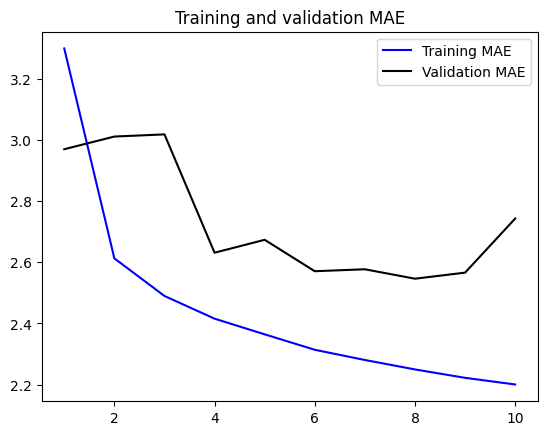

In [10]:
# train the model
import keras
from keras import layers

# Define model architecture
inputs = keras.Input(shape=(sequence_length * raw_data.shape[-1],))
#x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("models/jena_dense.keras",
                                    save_best_only=True)
]

# Set model parameters
model.compile(optimizer= keras.optimizers.RMSprop(), # SGD, Adam, RMSProp
              loss= keras.losses.MeanSquaredError(),
              metrics= [keras.metrics.MeanAbsoluteError(name="mae")])

# Train the model
history = model.fit(train_dataset_fl,
                    epochs=10,
                    validation_data=val_dataset_fl,
                    callbacks=callbacks)

model = keras.models.load_model("models/jena_dense.keras")

# Evaluate the model on the test set
val_loss= model.evaluate(val_dataset_fl)
test_loss = model.evaluate(test_dataset_fl)
train_loss = model.evaluate(train_dataset_fl)
print(f"Train      MAE: {train_loss[1]:.2f}")
print(f"Validation MAE: {val_loss[1]:.2f}")
print(f"Test       MAE: {test_loss[1]:.2f}")


# Add results to the dataframe:
new_entry = {
    "Model Name" : "Simple MLP",
    "Details" : 16,
    "Train MAE" : train_loss[1],
    "Val MAE" : val_loss[1],
    "Test MAE" : test_loss[1],
}
results_df = pd.concat([results_df, pd.DataFrame([new_entry])], ignore_index=True)

# View and and save the dataframe:
print("Results:")
print(results_df)
results_df.to_csv("models/jena_results.csv", index=False)

# plot the training progress:
import matplotlib.pyplot as plt

history_dict = history.history
print(history_dict.keys())

import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "b", label="Training MAE")
plt.plot(epochs, val_loss, "k", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [11]:

# Plot the real and predicted values
import matplotlib.pyplot as plt

def plot_predictions(dataset, model, num_samples=24):
    """Plots predicted vs. real outputs."""
    preds_list = []
    targets_list = []

    samples_seen = 0
    for samples, targets in dataset:
        preds = model.predict(samples)
        #preds_list.extend(preds)
        preds_list.extend(preds.reshape(-1))
        targets_list.extend(targets)
        samples_seen += samples.shape[0]
        if samples_seen >= num_samples:
            break

    plt.figure(figsize=(10, 6))
    plt.plot(targets_list[:num_samples], label='Real Values')
    plt.plot(preds_list[:num_samples], label='Predicted Values')
    plt.xlabel('Sample Index')
    plt.ylabel('Temperature (°C)')
    plt.title('Predicted vs. Real Temperature')
    plt.legend()
    plt.show()



8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


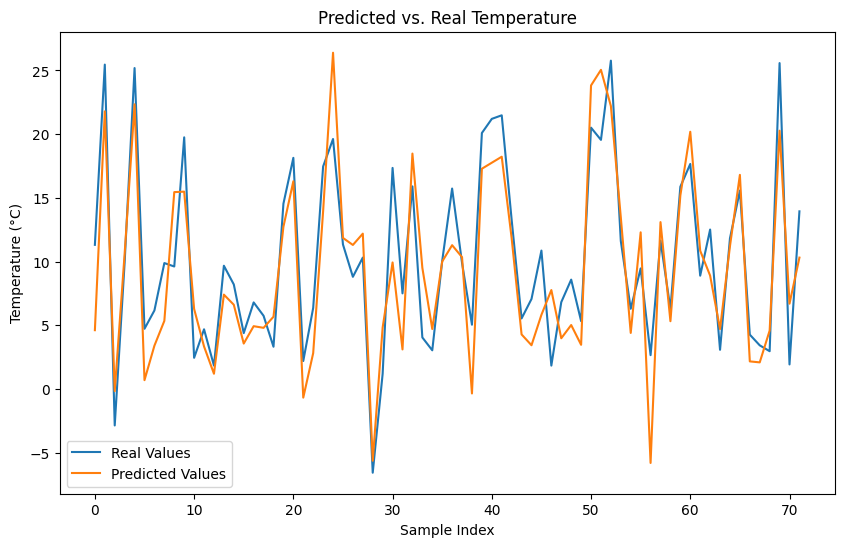

In [12]:
model = keras.models.load_model("models/jena_dense.keras")
plot_predictions(test_dataset_fl, model, 72)

##  A 1D convolutional model

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 120, 14)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 97, 8)               │           2,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 48, 8)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 37, 8)               │             776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 18, 8)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 13, 8)               │             392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 8)                   │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,873 (15.13 KB)

 Trainable params: 3,873 (15.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 43s 48ms/step - loss: 30.8951 - mae: 4.2756 - val_loss: 15.1289 - val_mae: 3.0856
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 77s 45ms/step - loss: 17.8966 - mae: 3.3071 - val_loss: 14.5876 - val_mae: 3.0268
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 50s 56ms/step - loss: 15.5079 - mae: 3.0911 - val_loss: 15.6896 - val_mae: 3.1231
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 46s 56ms/step - loss: 13.9649 - mae: 2.9480 - val_loss: 13.5621 - val_mae: 2.8980
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 82s 56ms/step - loss: 13.0638 - mae: 2.8554 - val_loss: 16.5264 - val_mae: 3.2147
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 72s 43ms/step - loss: 12.5519 - mae: 2.8016 - val_loss: 13.1136 - val_mae: 2.8453
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 34s 41ms/step - loss: 12.0619 - mae: 2.7442 - val_loss: 14.0351 - val_mae: 2.9553
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 38s 47ms/step - loss: 11.7145 - mae: 2.7026 - val_loss: 13.7717 - val_mae: 2.9101
Epoch 9/10
819/819 ━━━━━

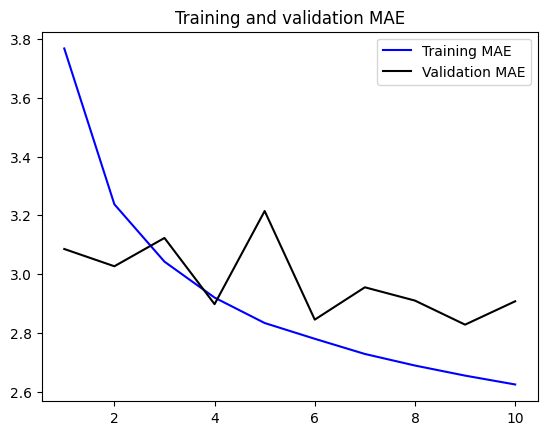

In [13]:
# Define model architecture
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
model.summary()

# Set model parameters
model.compile(optimizer= keras.optimizers.RMSprop(), # SGD, Adam, RMSProp
              loss= keras.losses.MeanSquaredError(),
              metrics= [keras.metrics.MeanAbsoluteError(name="mae")])

# Train the model
callbacks = [
    keras.callbacks.ModelCheckpoint("models/jena_conv.keras",
                                    save_best_only=True)
]

history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("models/jena_conv.keras")

# Evaluate the model on the test set
val_loss= model.evaluate(val_dataset)
test_loss = model.evaluate(test_dataset)
train_loss = model.evaluate(train_dataset)
print(f"Train      MAE: {train_loss[1]:.2f}")
print(f"Validation MAE: {val_loss[1]:.2f}")
print(f"Test       MAE: {test_loss[1]:.2f}")


# Add results to the dataframe:
new_entry = {
    "Model Name" : "Simple CNN",
    "Details" : "24 ",
    "Train MAE" : train_loss[1],
    "Val MAE" : val_loss[1],
    "Test MAE" : test_loss[1],
}
results_df = pd.concat([results_df, pd.DataFrame([new_entry])], ignore_index=True)

# View and and save the dataframe:
print("Results:")
print(results_df)
results_df.to_csv("models/jena_results.csv", index=False)

# plot the training progress:
import matplotlib.pyplot as plt

history_dict = history.history
print(history_dict.keys())

import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "b", label="Training MAE")
plt.plot(epochs, val_loss, "k", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


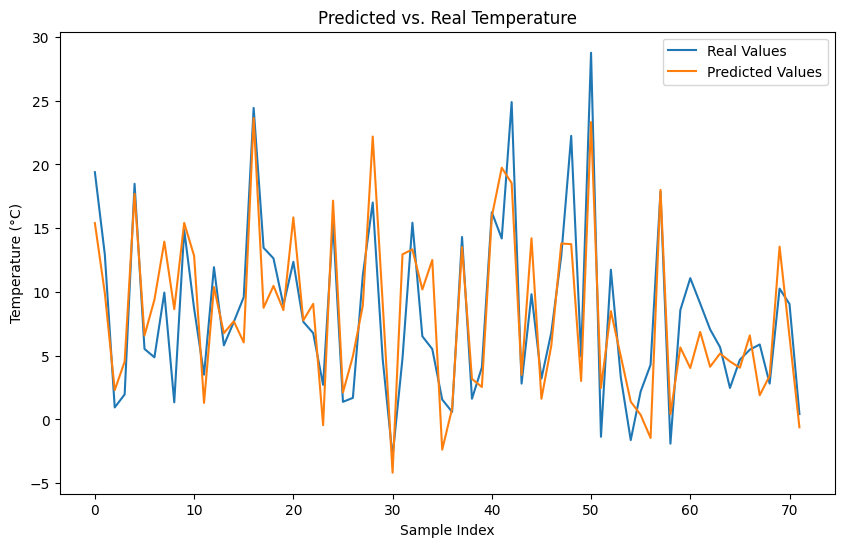

In [14]:
model = keras.models.load_model("models/jena_conv.keras")
plot_predictions(test_dataset, model, 72)

# A simple LSTM-based model





Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 120, 14)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 16)                  │           1,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,001 (7.82 KB)

 Trainable params: 2,001 (7.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 43s 50ms/step - loss: 65.3737 - mae: 6.1266 - val_loss: 11.8986 - val_mae: 2.6253
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 80s 49ms/step - loss: 11.4674 - mae: 2.6388 - val_loss: 9.7693 - val_mae: 2.4398
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 41s 48ms/step - loss: 10.0903 - mae: 2.4821 - val_loss: 9.5076 - val_mae: 2.3937
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - loss: 9.5403 - mae: 2.4098 - val_loss: 9.4448 - val_mae: 2.3982
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 39s 48ms/step - loss: 9.1254 - mae: 2.3553 - val_loss: 9.2740 - val_mae: 2.3896
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 42s 49ms/step - loss: 8.8489 - mae: 2.3176 - val_loss: 9.3375 - val_mae: 2.3982
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 41s 49ms/step - loss: 8.6581 - mae: 2.2932 - val_loss: 9.4742 - val_mae: 2.4074
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 40s 49ms/step - loss: 8.4593 - mae: 2.2637 - val_loss: 9.2611 - val_mae: 2.3957
Epoch 9/10
819/819 ━━━━━━━━━━━━━━━━━

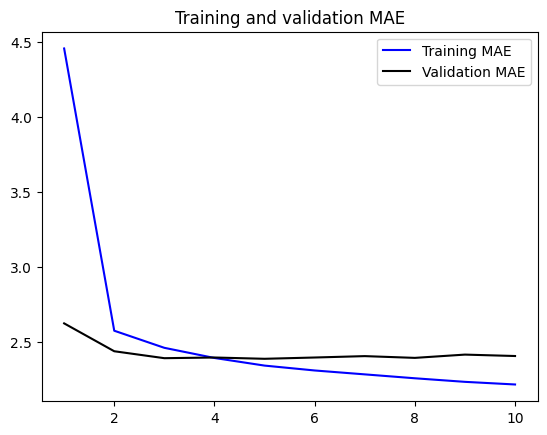

In [15]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
model.summary()


callbacks = [
    keras.callbacks.ModelCheckpoint("models/jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("models/jena_lstm.keras")

# Evaluate the model on the test set
val_loss= model.evaluate(val_dataset)
test_loss = model.evaluate(test_dataset)
train_loss = model.evaluate(train_dataset)
print(f"Train      MAE: {train_loss[1]:.2f}")
print(f"Validation MAE: {val_loss[1]:.2f}")
print(f"Test       MAE: {test_loss[1]:.2f}")


# Add results to the dataframe:
new_entry = {
    "Model Name" : "Simple LSTM",
    "Details" : 16,
    "Train MAE" : train_loss[1],
    "Val MAE" : val_loss[1],
    "Test MAE" : test_loss[1],
}
results_df = pd.concat([results_df, pd.DataFrame([new_entry])], ignore_index=True)

# View and and save the dataframe:
print("Results:")
print(results_df)
results_df.to_csv("models/jena_results.csv", index=False)

# plot the training progress:
import matplotlib.pyplot as plt

history_dict = history.history
print(history_dict.keys())

import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "b", label="Training MAE")
plt.plot(epochs, val_loss, "k", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  


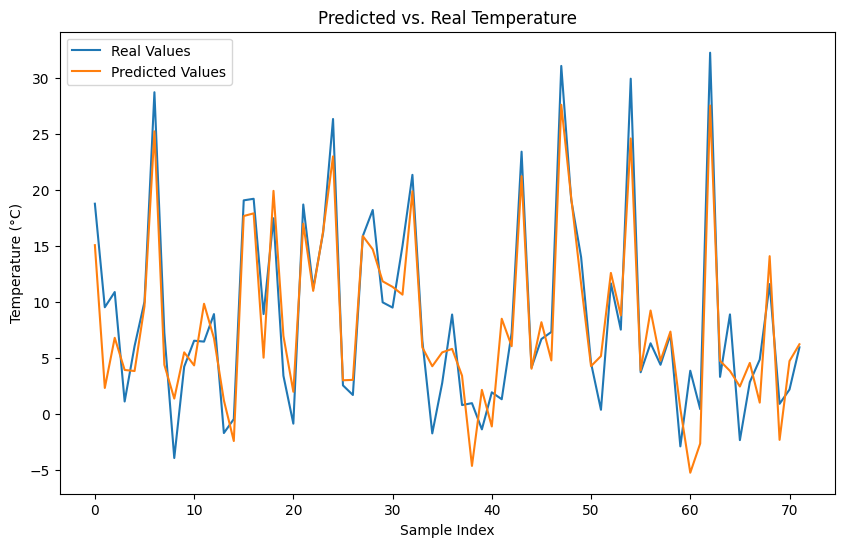

In [16]:
model = keras.models.load_model("models/jena_lstm.keras")
plot_predictions(test_dataset, model, 72)

## LSTM with dropout and gradient clipping

In [ ]:
# Define model architecture
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
#x = layers.LSTM(32, recurrent_dropout=0.25)(inputs) # change 16 -> 32.
x = layers.Dropout(0.5)(x)                          # dropout layer
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
model.summary()


callbacks = [
    keras.callbacks.ModelCheckpoint("models/jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer=keras.optimizers.RMSprop(clipnorm=1.0),  # change
               loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=20, # change
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("models/jena_lstm_dropout.keras")

# Evaluate the model on the test set
val_loss= model.evaluate(val_dataset)
test_loss = model.evaluate(test_dataset)
train_loss = model.evaluate(train_dataset)
print(f"Train      MAE: {train_loss[1]:.2f}")
print(f"Validation MAE: {val_loss[1]:.2f}")
print(f"Test       MAE: {test_loss[1]:.2f}")


# Add results to the dataframe:
new_entry = {
    "Model Name" : "Regularized LSTM",
    "Details" : "dropout",
    "Train MAE" : train_loss[1],
    "Val MAE" : val_loss[1],
    "Test MAE" : test_loss[1],
}
results_df = pd.concat([results_df, pd.DataFrame([new_entry])], ignore_index=True)

# View and and save the dataframe:
print("Results:")
print(results_df)
results_df.to_csv("models/jena_results.csv", index=False)

# plot the training progress:
import matplotlib.pyplot as plt

history_dict = history.history
print(history_dict.keys())

import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "b", label="Training MAE")
plt.plot(epochs, val_loss, "k", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)          │ (None, 120, 14)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_15 (LSTM)                       │ (None, 32)                  │           6,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,049 (23.63 KB)

 Trainable params: 6,049 (23.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 293s 355ms/step - loss: 54.7641 - mae: 5.4982 - val_loss: 9.8227 - val_mae: 2.4360
Epoch 2/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - loss: 15.4047 - mae: 3.0558

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


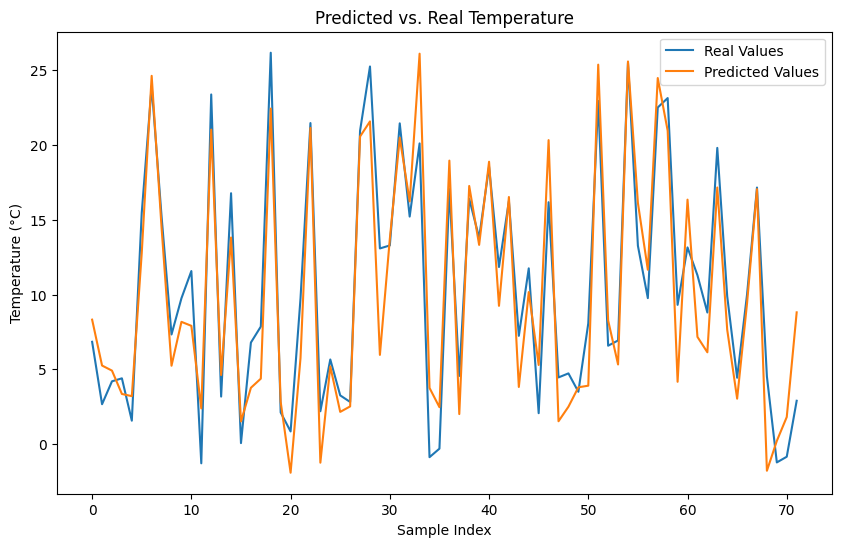

In [18]:
model = keras.models.load_model("models/jena_lstm_dropout.keras")
plot_predictions(test_dataset, model, 72)

## GRU with more layers

In [19]:
# Define model architecture
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
#x = layers.GRU(26, recurrent_dropout=0.5, return_sequences=True)(inputs)
#x = layers.GRU(26, recurrent_dropout=0.5)(x)
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
model.summary()


callbacks = [
    keras.callbacks.ModelCheckpoint("models/jena_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer=keras.optimizers.RMSprop(clipnorm=1.0),  # change
              loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=30, # change
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("models/jena_gru_dropout.keras")

# Evaluate the model on the test set
val_loss= model.evaluate(val_dataset)
test_loss = model.evaluate(test_dataset)
train_loss = model.evaluate(train_dataset)
print(f"Train      MAE: {train_loss[1]:.2f}")
print(f"Validation MAE: {val_loss[1]:.2f}")
print(f"Test       MAE: {test_loss[1]:.2f}")


# Add results to the dataframe:
new_entry = {
    "Model Name" : "Multilayer GRU",
    "Details" : "dropout",
    "Train MAE" : train_loss[1],
    "Val MAE" : val_loss[1],
    "Test MAE" : test_loss[1],
}
results_df = pd.concat([results_df, pd.DataFrame([new_entry])], ignore_index=True)

# View and and save the dataframe:
print("Results:")
print(results_df)
results_df.to_csv("models/jena_results.csv", index=False)

# plot the training progress:
import matplotlib.pyplot as plt

history_dict = history.history
print(history_dict.keys())

import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "b", label="Training MAE")
plt.plot(epochs, val_loss, "k", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

Epoch 1/30
660/819 ━━━━━━━━━━━━━━━━━━━━ 1:19 497ms/step - loss: nan - mae: nan

KeyboardInterrupt: 

In [ ]:
model = keras.models.load_model("models/jena_gru_dropout.keras")
plot_predictions(test_dataset, model, 72)

## Bidirectional RNN

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 44s 52ms/step - loss: 55.0950 - mae: 5.4943 - val_loss: 10.8154 - val_mae: 2.5619
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 82s 53ms/step - loss: 10.1037 - mae: 2.4806 - val_loss: 9.7966 - val_mae: 2.4311
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 45s 54ms/step - loss: 8.9463 - mae: 2.3208 - val_loss: 9.4498 - val_mae: 2.3852
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 82s 54ms/step - loss: 8.3745 - mae: 2.2490 - val_loss: 9.5292 - val_mae: 2.3935
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 82s 54ms/step - loss: 7.9624 - mae: 2.1965 - val_loss: 9.7580 - val_mae: 2.4239
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 43s 52ms/step - loss: 7.5899 - mae: 2.1468 - val_loss: 9.6972 - val_mae: 2.4084
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 45s 55ms/step - loss: 7.2984 - mae: 2.1075 - val_loss: 10.0120 - val_mae: 2.4463
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 81s 54ms/step - loss: 7.0642 - mae: 2.0743 - val_loss: 10.3249 - val_mae: 2.4776
Epoch 9/10
819/819 ━━━━━━━━━━━━━━━━

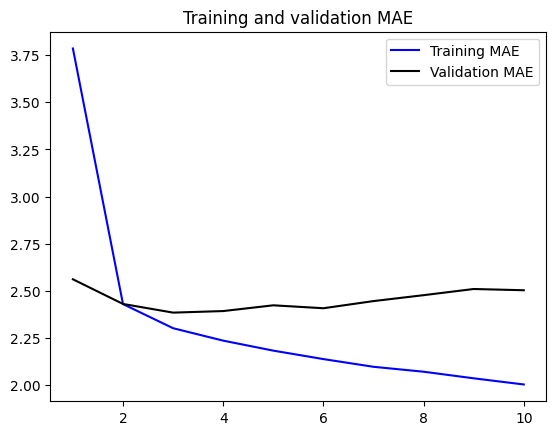

In [23]:
# Define model architecture
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("models/jena_bi.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10, # change
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("models/jena_bi.keras")

# Evaluate the model on the test set
val_loss= model.evaluate(val_dataset)
test_loss = model.evaluate(test_dataset)
train_loss = model.evaluate(train_dataset)
print(f"Train      MAE: {train_loss[1]:.2f}")
print(f"Validation MAE: {val_loss[1]:.2f}")
print(f"Test       MAE: {test_loss[1]:.2f}")


# Add results to the dataframe:
new_entry = {
    "Model Name" : "Bidirectional RNN",
    "Details" : "LSTM",
    "Train MAE" : train_loss[1],
    "Val MAE" : val_loss[1],
    "Test MAE" : test_loss[1],
}
results_df = pd.concat([results_df, pd.DataFrame([new_entry])], ignore_index=True)

# View and and save the dataframe:
print("Results:")
print(results_df)
results_df.to_csv("models/jena_results.csv", index=False)

# plot the training progress:
import matplotlib.pyplot as plt

history_dict = history.history
print(history_dict.keys())

import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "b", label="Training MAE")
plt.plot(epochs, val_loss, "k", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()